# Clustering football events based on their event_type

In [124]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, davies_bouldin_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import nltk
import re
from tqdm import tqdm

In [125]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [126]:
# --- Load the dataset ---
print("Step 1: Loading the dataset...")
file_path = '../data/events.csv'
events = pd.read_csv(file_path)

Step 1: Loading the dataset...


In [127]:
# Check the initial dataset
print(f"Dataset loaded with shape: {events.shape}")
print("Here are the first few rows of the dataset:")
print(events.head())

Dataset loaded with shape: (941009, 22)
Here are the first few rows of the dataset:
     id_odsp   id_event  sort_order  time  \
0  UFot0hit/  UFot0hit1           1     2   
1  UFot0hit/  UFot0hit2           2     4   
2  UFot0hit/  UFot0hit3           3     4   
3  UFot0hit/  UFot0hit4           4     7   
4  UFot0hit/  UFot0hit5           5     7   

                                                text  event_type  event_type2  \
0  Attempt missed. Mladen Petric (Hamburg) left f...           1         12.0   
1  Corner,  Borussia Dortmund. Conceded by Dennis...           2          NaN   
2  Corner,  Borussia Dortmund. Conceded by Heiko ...           2          NaN   
3           Foul by Sven Bender (Borussia Dortmund).           3          NaN   
4  Gokhan Tore (Hamburg) wins a free kick in the ...           8          NaN   

   side         event_team           opponent  ... player_in player_out  \
0     2         Hamburg SV  Borussia Dortmund  ...       NaN        NaN   
1     1 

In [128]:
# I want to figure out how many entries for each event_type we have
print("Number of entries for each event_type:")
print(events['event_type'].value_counts())

Number of entries for each event_type:
event_type
8     237932
3     232925
1     229135
2      91204
7      51738
9      43476
4      39911
10     10730
11      2706
6       1152
5        100
Name: count, dtype: int64


In [129]:
# --- Filter Event Types ---
print("Step 2: Filtering event types...")
valid_event_types = events['event_type'].value_counts()
valid_event_types = valid_event_types[valid_event_types >= 1152].index.tolist()
filtered_events = events[events['event_type'].isin(valid_event_types)]

Step 2: Filtering event types...


In [130]:
valid_event_types

[8, 3, 1, 2, 7, 9, 4, 10, 11, 6]

In [131]:
filtered_events

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941004,z5L2OT5E/,z5L2OT5E123,123,92,Lucas Torreira (Sampdoria) wins a free kick in...,8,NaN,2,Sampdoria,Atalanta,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
941005,z5L2OT5E/,z5L2OT5E124,124,93,"Corner, Sampdoria. Conceded by Andrea Masiello.",2,NaN,2,Sampdoria,Atalanta,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
941006,z5L2OT5E/,z5L2OT5E125,125,93,Attempt missed. Fabio Quagliarella (Sampdoria)...,1,12.0,2,Sampdoria,Atalanta,...,NaN,NaN,8.0,2.0,0,9.0,1.0,1,3.0,0
941007,z5L2OT5E/,z5L2OT5E126,126,94,Alberto Grassi (Atalanta) wins a free kick on ...,8,NaN,1,Atalanta,Sampdoria,...,NaN,NaN,NaN,NaN,0,4.0,NaN,0,NaN,0


In [132]:
# --- Balanced Sampling and Oversampling ---
print("Step 3: Balancing dataset with oversampling...")
ros = RandomOverSampler(random_state=42)
balanced_features, balanced_labels = ros.fit_resample(
    filtered_events[['text', 'is_goal', 'location', 'assist_method']],
    filtered_events['event_type']
)
balanced_events = pd.DataFrame(balanced_features, columns=['text', 'is_goal', 'location', 'assist_method'])
balanced_events['event_type'] = balanced_labels

Step 3: Balancing dataset with oversampling...


In [133]:
balanced_events

,text,is_goal,location,assist_method,event_type
0,Attempt missed. Mladen Petric (Hamburg) left f...,0,9.0,1,1
1,"Corner, Borussia Dortmund. Conceded by Dennis...",0,NaN,0,2
2,"Corner, Borussia Dortmund. Conceded by Heiko ...",0,NaN,0,2
3,Foul by Sven Bender (Borussia Dortmund).,0,NaN,0,3
4,Gokhan Tore (Hamburg) wins a free kick in the ...,0,2.0,0,8
...,...,...,...,...,...
2379315,Penalty Juventus. Marco Borriello draws a foul...,0,NaN,0,11
2379316,Penalty Roma. Mattia Destro draws a foul in th...,0,NaN,0,11
2379317,Penalty conceded by Jose Fonte (Southampton) a...,0,NaN,0,11
2379318,Penalty conceded by Stefano Lucchini (Cesena) ...,0,NaN,0,11


In [134]:
# Sample smaller dataset for processing speed
balanced_events = balanced_events.sample(20000, random_state=42)

In [135]:
# --- Text Preprocessing ---
print("Step 4: Preprocessing text...")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

Step 4: Preprocessing text...


In [136]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d', '', text)  # Remove digits
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [137]:
# Apply text preprocessing
balanced_events['processed_text'] = balanced_events['text'].apply(preprocess_text)

In [138]:
# Show some examples of preprocessed text
print("Examples of preprocessed text:")
print(balanced_events[['text', 'processed_text']].head())

Examples of preprocessed text:
                                                      text  \
1367953            Francis (Racing) is shown the red card.   
702110               Foul by Steven Fletcher (Sunderland).   
713667   Roque (Las Palmas) wins a free kick in the att...   
1919616  Hand ball by Zlatan Ibrahimovic (Paris Saint G...   
1547537  Substitution, Schalke. Ciprian Marica replaces...   

                                            processed_text  
1367953                      francis racing shown red card  
702110                     foul steven fletcher sunderland  
713667        roque la palmas win free kick attacking half  
1919616   hand ball zlatan ibrahimovic paris saint germain  
1547537  substitution schalke ciprian marica replaces j...  


In [139]:
# --- Convert Text to Numerical Representation Using TF-IDF ---
print("\nStep 5: Converting text to numerical representation using TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
text_features = tfidf_vectorizer.fit_transform(balanced_events['processed_text']).toarray()



Step 5: Converting text to numerical representation using TF-IDF...


In [140]:
# --- Standardize Numerical Features ---
scaler = StandardScaler()
numerical_features = balanced_events[['is_goal', 'location', 'assist_method']].fillna(0).astype(float)
scaled_numerical_features = scaler.fit_transform(numerical_features)

In [141]:
# Combine all features
combined_features = np.hstack([text_features, scaled_numerical_features])

In [142]:
# --- Apply OPTICS Clustering ---
print("\nStep 6: Applying OPTICS clustering...")
optics = OPTICS(min_samples=15, metric='cosine', cluster_method='xi', xi=0.05)
optics.fit(combined_features)


Step 6: Applying OPTICS clustering...


OPTICS(metric='cosine', min_samples=15)

In [143]:
# Assign cluster labels
balanced_events['cluster'] = optics.labels_

In [144]:
# Print cluster information
print(f"Number of clusters found (including noise): {balanced_events['cluster'].nunique()}")
print("Cluster distribution:")
print(balanced_events['cluster'].value_counts())

Number of clusters found (including noise): 178
Cluster distribution:
cluster
-1      15927
 153       74
 95        62
 68        48
 81        45
        ...  
 21        15
 29        15
 8         15
 46        15
 10        15
Name: count, Length: 178, dtype: int64


In [145]:
# --- Evaluate the Clustering ---
print("\nStep 7: Evaluating the clustering...")
# Exclude noise points (-1)
valid_indices = balanced_events['cluster'] != -1
valid_clusters = balanced_events[valid_indices]


Step 7: Evaluating the clustering...


In [146]:
# Metrics
if valid_clusters['cluster'].nunique() > 1:
    silhouette = silhouette_score(combined_features[valid_indices], valid_clusters['cluster'])
    ari = adjusted_rand_score(valid_clusters['event_type'], valid_clusters['cluster'])
    homogeneity = homogeneity_score(valid_clusters['event_type'], valid_clusters['cluster'])
    dbi = davies_bouldin_score(combined_features[valid_indices], valid_clusters['cluster'])
else:
    silhouette = ari = homogeneity = dbi = "Not Applicable"

print("\nClustering Metrics:")
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Homogeneity Score: {homogeneity}")
print(f"Davies-Bouldin Index: {dbi}")


Clustering Metrics:
Silhouette Score: 0.3860297879799421
Adjusted Rand Index (ARI): 0.03328725774038781
Homogeneity Score: 0.5650108693974707
Davies-Bouldin Index: 1.1816685852723936


In [90]:
# --- Visualize Clusters ---
print("\nStep 8: Visualizing clusters...")
pca = PCA(n_components=2)
pca_features = pca.fit_transform(combined_features)


Step 7: Visualizing clusters...


Visualizing clusters...


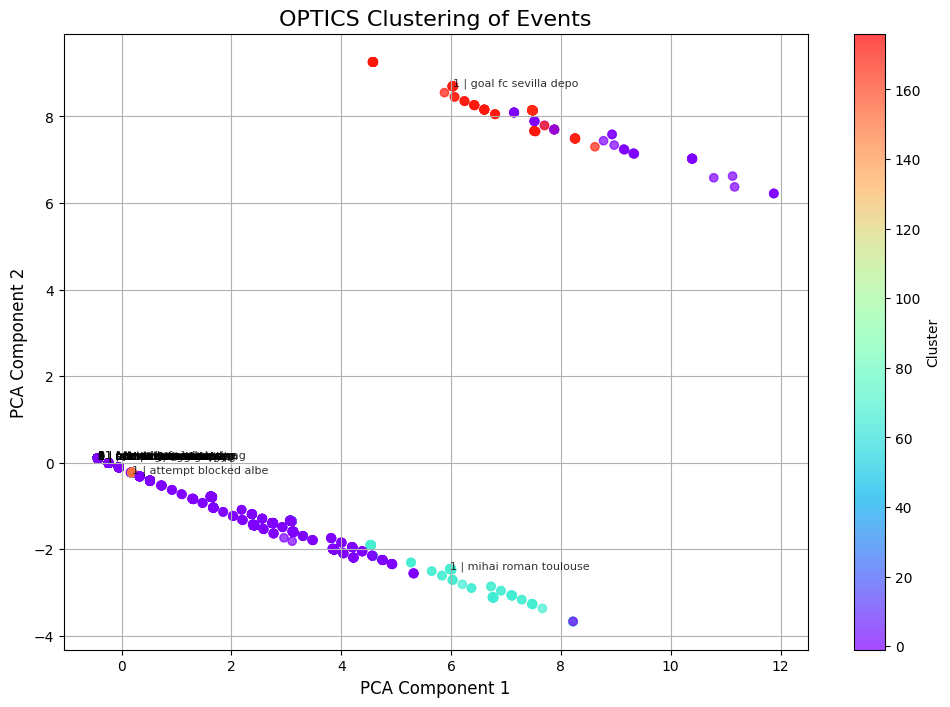

In [159]:
# Step 7: Visualize Clusters
print("Visualizing clusters...")
pca = PCA(n_components=2)
pca_features = pca.fit_transform(combined_features)

# Scatter Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_features[:, 0],
    pca_features[:, 1],
    c=balanced_events['cluster'],
    cmap='rainbow',
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title("OPTICS Clustering of Events", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)

# Annotate Sample Events
# Map indices of valid clusters to the PCA feature indices
valid_indices = valid_clusters.index.to_numpy()
sample_indices = np.random.choice(valid_indices, size=20, replace=False)  # Sample 20 points

for i in sample_indices:
    # Get the index in the PCA features array
    pca_idx = np.where(balanced_events.index == i)[0][0]
    
    event_type = valid_clusters.loc[i, 'event_type']
    text_snippet = valid_clusters.loc[i, 'processed_text'][:20]  # Limit to 20 characters
    
    plt.text(
        pca_features[pca_idx, 0],
        pca_features[pca_idx, 1],
        f"{event_type} | {text_snippet}",
        fontsize=8,
        alpha=0.8
    )

plt.show()


In [162]:
# --- Analyze Cluster Composition ---
print("\nStep 9: Analyzing cluster composition...")
cluster_composition = valid_clusters.groupby('cluster')['event_type'].value_counts(normalize=True)
print("Cluster Composition by Event Type:")
print(cluster_composition)


Step 9: Analyzing cluster composition...
Cluster Composition by Event Type:
cluster  event_type
0        4             1.000000
1        10            0.560000
         2             0.280000
         3             0.160000
2        2             0.562500
                         ...   
176      2             0.117647
         3             0.117647
         6             0.117647
         11            0.117647
         10            0.058824
Name: proportion, Length: 629, dtype: float64
